# Link Prediction - Data Preparation & Feature Engineering

# Imports

In [1]:
import ast
import gzip
import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch

from sentence_transformers import SentenceTransformer
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.nn.models import Node2Vec
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import from_networkx, to_networkx, negative_sampling
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <96E2C2A1-D31F-3F37-9DC7-15611722739E> /Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warni

# Data Preparation

### Recreating the community subgraph

In [2]:
def load_graph(file_path):
    edges = []
    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return nx.Graph(edges)


def extract_top_communities_subgraph(G, community_path):

    community_map = {}
    community_id = 0

    # Read top-k communities and build the node set
    with gzip.open(community_path, "rt") as f:
        for line in f:
            nodes = list(map(int, line.strip().split("\t")))
            for node in nodes:
                if node in G and node not in community_map:
                    community_map[node] = community_id
            community_id += 1

    top_k_nodes = set(community_map.keys())

    # Include all edges where at least one node is in top-k
    expanded_edges = [
        (u, v) for u, v in G.edges() if u in top_k_nodes or v in top_k_nodes
    ]

    # Build the new graph
    G_expanded = nx.Graph()
    G_expanded.add_edges_from(expanded_edges)

    return G_expanded, community_map

In [3]:
graph = load_graph(file_path="data/raw/com-amazon.ungraph.txt.gz")
G, community_map = extract_top_communities_subgraph(
    graph, "data/raw/com-amazon.top5000.cmty.txt.gz"
)

print(
    f"Top-5000 expanded subgraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges"
)

Top-5000 expanded subgraph has 19905 nodes and 53780 edges


In [4]:
data = from_networkx(G)
data.num_nodes = G.number_of_nodes()
print(data)

Data(edge_index=[2, 107560], num_nodes=19905)


In [5]:
metadata_df = pd.read_csv("data/raw/amazon_metadata.csv")

In [6]:
metadata_df.iloc[75].to_dict()

{'id': 75,
 'asin': '0786863919',
 'title': 'Disney A to Z : The Updated Official Encyclopedia (Disney a to Z)',
 'group': 'Book',
 'salesrank': 161879.0,
 'categories': "['|Books[283155]|Subjects[1000]|Entertainment[86]|Movies[4484]|Reference[4498]', '|Books[283155]|Subjects[1000]|Entertainment[86]|Television[4569]|Reference[4574]', '|Books[283155]|Subjects[1000]|Home & Garden[48]|Antiques & Collectibles[5066]|Americana[5067]', '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Art[11716]', '|Books[283155]|Subjects[1000]|Entertainment[86]|Movies[4484]|Encyclopedias[11726]', '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Pop Culture[11751]', '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Television[11757]', 'reviews: total: 9  downloaded: 9  avg rating: 4.5', '1998-9-22  cutomer:  ATVPDKIKX0DER  rating: 5  votes:   4  helpful:   4', '1998-12-24  cutomer:  ATVPDKIKX0DER  rating: 5  votes:   8  helpful:   8', '1999-6-16  cutomer:  ATVP

In [7]:
def clean_categories(row):
    try:
        items = ast.literal_eval(row)  # turn string into list
        return [x for x in items if "|" in x and "review" not in x.lower()]
    except:
        return []

In [8]:
metadata_df["categories"] = metadata_df["categories"].apply(clean_categories)

In [9]:
metadata_df.iloc[75].to_dict()

{'id': 75,
 'asin': '0786863919',
 'title': 'Disney A to Z : The Updated Official Encyclopedia (Disney a to Z)',
 'group': 'Book',
 'salesrank': 161879.0,
 'categories': ['|Books[283155]|Subjects[1000]|Entertainment[86]|Movies[4484]|Reference[4498]',
  '|Books[283155]|Subjects[1000]|Entertainment[86]|Television[4569]|Reference[4574]',
  '|Books[283155]|Subjects[1000]|Home & Garden[48]|Antiques & Collectibles[5066]|Americana[5067]',
  '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Art[11716]',
  '|Books[283155]|Subjects[1000]|Entertainment[86]|Movies[4484]|Encyclopedias[11726]',
  '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Pop Culture[11751]',
  '|Books[283155]|Subjects[1000]|Reference[21]|Encyclopedias[11713]|Television[11757]'],
 'avg_rating': nan,
 'num_reviews': nan}

### Feature Engineering - Approach 1

Extract **numeric features** directly from metadata:

- `salesrank`: Product’s sales rank (higher = less popular)
- `avg_rating`: Average review rating
- `num_reviews`: Number of reviews

Fill missing values with 0, use standard scaler normalization.

Extract **categorical features** using a multilabel binarizer.

- if a product belongs to multiple categories, all are marked with 1s in the corresponding columns.

In [10]:
def build_feature_matrix_train(G, metadata_df, use_title_feats=True):

    node_ids = list(G.nodes())
    node_df = pd.DataFrame({"id": node_ids})
    merged = node_df.merge(metadata_df, on="id", how="left")

    # Fill missing values and derive new features
    merged["salesrank"] = merged["salesrank"].fillna(0)
    merged["avg_rating"] = merged["avg_rating"].fillna(0)
    merged["num_reviews"] = merged["num_reviews"].fillna(0)
    merged["log_salesrank"] = np.log1p(merged["salesrank"])

    # Graph centralities (train only)
    import networkx as nx

    degree = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    try:
        eigenvector = nx.eigenvector_centrality_numpy(G)
    except:
        eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    merged["degree_centrality"] = merged["id"].map(degree)
    merged["closeness_centrality"] = merged["id"].map(closeness)
    merged["eigenvector_centrality"] = merged["id"].map(eigenvector)

    # Numerical features
    num_cols = [
        "log_salesrank",
        "avg_rating",
        "num_reviews",
        "degree_centrality",
        "closeness_centrality",
        "eigenvector_centrality",
    ]
    merged[num_cols] = merged[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    merged[num_cols] = merged[num_cols].clip(-1e5, 1e5)

    scaler = StandardScaler()
    num_feats = scaler.fit_transform(merged[num_cols])

    # One-hot encode 'group'
    group_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    group_feats = group_encoder.fit_transform(merged[["group"]].fillna("Unknown"))

    # Title embeddings
    if use_title_feats:
        model = SentenceTransformer("all-MiniLM-L6-v2")
        titles = merged["title"].fillna("").tolist()
        title_embeddings = []

        for emb in tqdm(
            model.encode(titles, batch_size=256, show_progress_bar=False),
            desc="Encoding Titles",
        ):
            title_embeddings.append(emb)

        title_embeddings = np.vstack(title_embeddings)
    else:
        model = None

    # Concatenate all features
    full_features = (
        np.hstack([num_feats, group_feats, title_embeddings])
        if use_title_feats
        else np.hstack([num_feats, group_feats])
    )
    feature_tensor = torch.tensor(full_features, dtype=torch.float32)

    # Save all for reuse
    torch.save(feature_tensor, f"data/processed/train_features.pt")
    joblib.dump(scaler, f"data/processed/scaler.pkl")
    joblib.dump(group_encoder, f"data/processed/group_encoder.pkl")
    np.save(f"data/processed/node_ids.npy", merged["id"].values)

    return feature_tensor, merged["id"].values, scaler, group_encoder, model

In [11]:
def build_feature_matrix_valtest(
    G, metadata_df, scaler, group_encoder, title_model, use_title_feats=True
):
    # Step 1: Align metadata to graph nodes
    node_ids = list(G.nodes())
    node_df = pd.DataFrame({"id": node_ids})
    merged = node_df.merge(metadata_df, on="id", how="left")

    # Step 2: Clean numeric fields
    merged["salesrank"] = merged["salesrank"].fillna(0)
    merged["avg_rating"] = merged["avg_rating"].fillna(0)
    merged["num_reviews"] = merged["num_reviews"].fillna(0)
    merged["log_salesrank"] = np.log1p(merged["salesrank"])

    # Step 3: Use dummy values for centrality metrics in val/test
    merged["degree_centrality"] = 0
    merged["closeness_centrality"] = 0
    merged["eigenvector_centrality"] = 0

    # Step 4: Normalize numeric + dummy centrality features using training scaler
    num_cols = [
        "log_salesrank",
        "avg_rating",
        "num_reviews",
        "degree_centrality",
        "closeness_centrality",
        "eigenvector_centrality",
    ]
    merged[num_cols] = merged[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    merged[num_cols] = merged[num_cols].clip(lower=-1e5, upper=1e5)
    num_feats = scaler.transform(merged[num_cols])

    # Step 5: Group one-hot encoding using fitted encoder
    group_feats = group_encoder.transform(merged[["group"]].fillna("Unknown"))

    # Step 6: Title embeddings using pretrained sentence transformer
    if use_title_feats:
        titles = merged["title"].fillna("").tolist()
        title_embeddings = []
        for i in tqdm(range(0, len(titles), 512), desc="Generating title embeddings"):
            batch = titles[i : i + 512]
            title_embeddings.extend(title_model.encode(batch, show_progress_bar=False))
        title_feats = np.array(title_embeddings)

    # Step 7: Concatenate all features
    x = (
        np.hstack([num_feats, group_feats, title_feats])
        if use_title_feats
        else np.hstack([num_feats, group_feats])
    )
    return torch.tensor(x, dtype=torch.float32), merged["id"].values

In [12]:
pyg_data = from_networkx(G)

splitter = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    num_val=0.15,
    num_test=0.15,
    split_labels=True,
)

train_data, val_data, test_data = splitter(pyg_data)

In [13]:
use_title_feats = True

train_nx = to_networkx(train_data, to_undirected=True)
x_train, node_ids, scaler, group_encoder, title_model = build_feature_matrix_train(
    train_nx, metadata_df, use_title_feats=use_title_feats
)

val_nx = to_networkx(val_data, to_undirected=True)
x_val, node_ids_val = build_feature_matrix_valtest(
    val_nx,
    metadata_df,
    scaler,
    group_encoder,
    title_model,
    use_title_feats=use_title_feats,
)

test_nx = to_networkx(test_data, to_undirected=True)
x_test, node_ids_test = build_feature_matrix_valtest(
    test_nx,
    metadata_df,
    scaler,
    group_encoder,
    title_model,
    use_title_feats=use_title_feats,
)

/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
Encoding Titles: 100%|██████████| 19905/19905 [00:00<00:00, 5276012.46it/s]
/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
Generating title embeddings: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
Generating title embeddings: 100%|██████████| 39/39 [00:11<00:00,  3.55it/s]


In [14]:
# Node features
train_data.x = x_train
val_data.x = x_val
test_data.x = x_test

# Graph structures for message passing
train_edge_index = train_data.edge_index
val_edge_index = val_data.edge_index
test_edge_index = test_data.edge_index


# Supervision labels
train_pos_edge_index = train_data.pos_edge_label_index
val_pos_edge_index = val_data.pos_edge_label_index
test_pos_edge_index = test_data.pos_edge_label_index

In [15]:
train_data.num_node_features, val_data.num_node_features, test_data.num_node_features

(396, 396, 396)

#### Something I Tried - Node2Vec Training for initializing node features (did not include this)

In [ ]:
# node2vec = Node2Vec(
#     data.edge_index,
#     embedding_dim=64,
#     walk_length=20,
#     context_size=10,
#     walks_per_node=10,
# )
# loader = node2vec.loader(batch_size=256, shuffle=True)

# optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.01)
# for epoch in tqdm(range(100)):
#     for pos_rw, neg_rw in loader:
#         loss = node2vec.loss(pos_rw, neg_rw)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

In [ ]:
# embeddings = node2vec.embedding.weight.detach()
# print(embeddings.shape)

# Training

In [16]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class DotProductDecoder(nn.Module):
    def __init__(self, embed_dim, dropout=0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * embed_dim, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(32, 1),
        )

    def forward(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        out = torch.cat([src, dst], dim=1)
        return self.mlp(out).squeeze()


class LinkPredictionModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels, out_channels, dropout)
        self.decoder = DotProductDecoder(out_channels, dropout)  # or use dot-product

    def forward(self, x, edge_index, edge_label_index):
        z = self.encoder(x, edge_index)
        return torch.sigmoid(self.decoder(z, edge_label_index))  # outputs probs

In [17]:
def create_edge_labels(data, pos_edge_index, num_neg_samples=None):
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_neg_samples or pos_edge_index.size(1),
        method="sparse",
    )

    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat(
        [torch.ones(pos_edge_index.size(1)), torch.zeros(neg_edge_index.size(1))]
    )
    return edge_label_index, edge_label

In [18]:
def train(model, x, edge_index, pos_edge_index, optimizer, device):
    model.train()
    optimizer.zero_grad()

    data = Data(x=x, edge_index=edge_index)

    edge_label_index, edge_label = create_edge_labels(
        data, pos_edge_index, num_neg_samples=None
    )
    edge_label_index = edge_label_index.to(device)
    edge_label = edge_label.to(device)

    pred = model(x.to(device), edge_index.to(device), edge_label_index)
    loss = F.binary_cross_entropy(pred, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

In [19]:
@torch.no_grad()
def evaluate(
    model,
    x,
    edge_index,
    pos_edge_index,
    device,
    num_neg_samples=1000,
    return_preds=False,
):
    model.eval()

    data = Data(x=x, edge_index=edge_index)

    edge_label_index, edge_label = create_edge_labels(
        data, pos_edge_index, num_neg_samples=num_neg_samples
    )
    edge_label_index = edge_label_index.to(device)
    edge_label = edge_label.to(device)

    pred = model(x.to(device), edge_index.to(device), edge_label_index)
    loss = F.binary_cross_entropy(pred, edge_label).item()

    pred_cpu = pred.detach().cpu()
    label_cpu = edge_label.detach().cpu()

    auc_score = roc_auc_score(label_cpu, pred_cpu)
    ap_score = average_precision_score(label_cpu, pred_cpu)

    if return_preds:
        return loss, auc_score, ap_score, pred_cpu, label_cpu
    else:
        return loss, auc_score, ap_score

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LinkPredictionModel(
    in_channels=train_data.num_node_features,
    hidden_channels=32,
    out_channels=16,
    dropout=0.5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [21]:
train_losses, val_losses = [], []
val_aucs, val_aps = [], []

best_val_auc = 0
patience = 10
patience_counter = 0
best_model_state = None
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    train_loss = train(
        model, x_train, train_edge_index, train_pos_edge_index, optimizer, device
    )
    train_losses.append(train_loss)

    val_loss, val_auc, val_ap = evaluate(
        model, x_val, val_edge_index, val_pos_edge_index, device
    )
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    val_aps.append(val_ap)

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | AP: {val_ap:.4f}"
        )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

Epoch 005 | Train Loss: 0.6964 | Val Loss: 0.6394 | AUC: 0.4932 | AP: 0.8855
Epoch 010 | Train Loss: 0.6939 | Val Loss: 0.6556 | AUC: 0.5039 | AP: 0.8883
Epoch 015 | Train Loss: 0.6916 | Val Loss: 0.6697 | AUC: 0.5142 | AP: 0.8939
Epoch 020 | Train Loss: 0.6894 | Val Loss: 0.6836 | AUC: 0.5198 | AP: 0.8973
Early stopping at epoch 24.


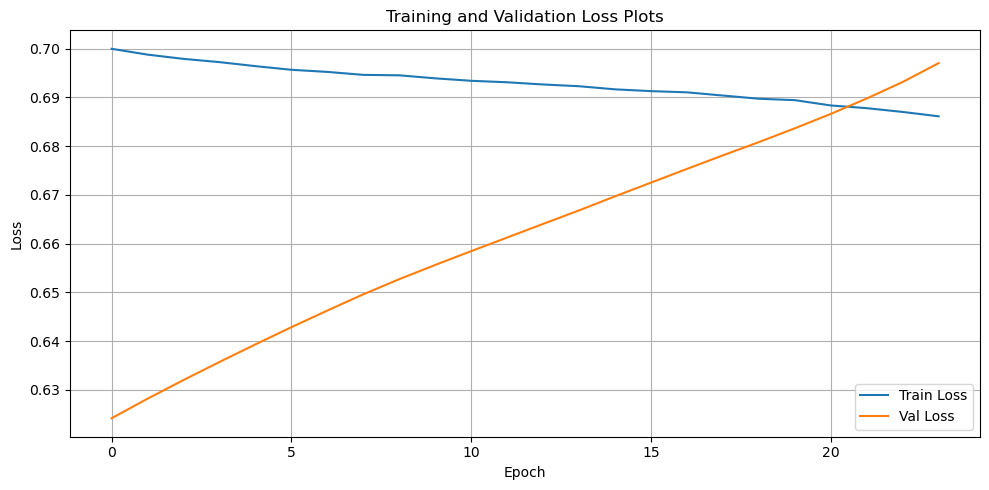

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Plots")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(best_model_state)

# Evaluate test set and retrieve predictions
test_loss, test_auc, test_ap, test_pred, test_label = evaluate(
    model, pyg_data, edge_split["test_pos"], device, return_preds=True
)

print(
    f"\n✅ Final Test Results | Loss: {test_loss:.4f} | AUC: {test_auc:.4f} | AP: {test_ap:.4f}"
)

In [ ]:
# Get predictions and labels
pred = test_pred.cpu().detach().numpy()
label = test_label.cpu().detach().numpy()

# ROC curve
fpr, tpr, _ = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(label, pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

### Masking of edges - inductive link prediction

In [ ]:
# Masking of edges
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=False,
)

train_data, val_data, test_data = transform(pyg_data)

In [ ]:
def train(model, data, pos_edge_label, optimizer, device):
    model.train()
    optimizer.zero_grad()

    edge_label_index, edge_label = create_edge_labels(
        data, pos_edge_label, num_neg_samples=None
    )
    edge_label_index = edge_label_index.to(device)
    edge_label = edge_label.to(device)

    out = model(data.x.to(device), data.edge_index.to(device), edge_label_index)
    loss = F.binary_cross_entropy(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def evaluate(
    model, data, pos_edge_label, device, num_neg_samples=1000, return_preds=False
):
    model.eval()

    edge_label_index, edge_label = create_edge_labels(
        data, pos_edge_label, num_neg_samples=num_neg_samples
    )
    edge_label_index = edge_label_index.to(device)
    edge_label = edge_label.to(device)

    pred = model(data.x.to(device), data.edge_index.to(device), edge_label_index)
    loss = F.binary_cross_entropy(pred, edge_label).item()

    pred_cpu = pred.detach().cpu()
    label_cpu = edge_label.detach().cpu()
    auc_score = roc_auc_score(label_cpu, pred_cpu)
    ap_score = average_precision_score(label_cpu, pred_cpu)

    if return_preds:
        return loss, auc_score, ap_score, pred_cpu, label_cpu
    else:
        return loss, auc_score, ap_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LinkPredictionModel(
    in_channels=pyg_data.num_node_features, hidden_channels=64, out_channels=32
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, val_losses = [], []
val_aucs, val_aps = [], []

best_val_auc = 0
patience = 10
patience_counter = 0
best_model_state = None
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    train_loss = train(
        model, train_data, train_data.pos_edge_label_index, optimizer, device
    )
    train_losses.append(train_loss)

    val_loss, val_auc, val_ap = evaluate(
        model, val_data, val_data.pos_edge_label_index, device
    )
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    val_aps.append(val_ap)

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | AP: {val_ap:.4f}"
        )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

In [ ]:
model.load_state_dict(best_model_state)

# Evaluate test set and retrieve predictions
test_loss, test_auc, test_ap, test_pred, test_label = evaluate(
    model, pyg_data, edge_split["test_pos"], device, return_preds=True
)

print(
    f"\n✅ Final Test Results | Loss: {test_loss:.4f} | AUC: {test_auc:.4f} | AP: {test_ap:.4f}"
)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Plots")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Get predictions and labels
pred = test_pred.cpu().detach().numpy()
label = test_label.cpu().detach().numpy()

# ROC curve
fpr, tpr, _ = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(label, pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()